# Método Convergencia y Confinamiento - Gonzales, Nuñez, Holguín

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

Propiedades geométricas del túnel

In [22]:
Z0=6.39 #profundidad del eje del túnel (m)
D=4.93 #ancho del túnel (m)
R=D/2 #radio del túnel (m)
t=0.05 #espesor del revestimiento (m)
H=6.78 #altura del túnel (m)
a=1 #avance sin sostenimiento (m)

Propiedades mecánicas del suelo

In [3]:
gamma_s=19 #peso específico del suelo (kN/m3)
phi=30 #angulo de fricción interna (°)
phi_rad=np.deg2rad(phi) #conversión a radianes de phi
c=15 #cohesion (kPa)
psi=1 #coeficiente de fractura de la corona plastificada (1=fragil, 0:ductil)
nus=0.3 #coeficiente de Poisson del suelo (-)
Es=5e4 #módulo de elasticidad del suelo (kPa)
K0=0.6 #coeficiente de empuje horizontal del suelo en reposo (-)

Propiedades mecánicas del hormigón

In [4]:
fc=17 #resistencia a la compresión simple del hormigón (MPa)
Ec=2.0e7 #módulo de elasticidad del hormigón (kPa)
nuc=0.16 #coeficiente de Poisson del hormigón (-)

# Curva desplazamiento-presion del suelo

En primer lugar calculamos el estado inicial de esfuerzos en la masa de suelo. Se considera un suelo cohesivo-friccionante.

In [5]:
sigma_0=gamma_s*Z0 #tensiones iniciales en el eje del túnel (kN/m2)

Ecuaciones que definen la curva de convergencia del suelo expresadas en forma de función.

In [6]:
pal=sigma_0*(1-np.sin(phi_rad))-c*np.cos(phi_rad) #tension limite de plastificación (kPa) - ec. 2.21

#Ecuación de desplazamiento en la clave
def us(p):
    if pa(p)>=pal:
        return ue(p) #régimen elástico --> ec. 2.20
    else:
        return up(p) #régimen plástico --> ec. 2.22

#Presión corregida - ec. 2.25    
def pa(p):
    if p >= pal:
        return p
    else:
        return p+gamma_s*(Rp(p)-D/2)*psi    
    
#Ecuación de desplazamiento en la clave en regimen elástico del suelo (m) - ec. 2.20
def ue(pa):
    return (gamma_s*Z0-pa)*(1+nus)*D/(2*Es) 

#Ecuación de desplazamiento en la clave en regimen plástico - ec. 2.22
def up(pa):
    return R*(1-np.sqrt(1/(1+ca(pa))))

#Coeficiente auxiliar para la ecuación en regimen plastico - ec. 2.23'
def ca(pa):
    return (2*(1+nus))/Es*(gamma_s*Z0+c/np.tan(phi_rad))*np.sin(phi_rad)*(Rp(pa)/R)**2

#Radio de plastificación (m) - ec. 2.24'
def Rp(pa):
    pot=(1-np.sin(phi_rad))/(2*np.sin(phi_rad))
    return D/2*((1-np.sin(phi_rad))*(gamma_s*Z0+c/np.tan(phi_rad))/(pa+c/np.tan(phi_rad)))**pot #

# Curva desplazamiento-presion del revestimiento

Se considera un revestimiento de hormigón proyectado y un avance a frente abierto.


In [23]:
#Rigidez del sostenimiento - tabla E.1
k=Ec/(1+nuc)*(R**2-(R-t)**2)/((1-2*nuc)*R**2+(R-t)**2) 

#Dezplazamiento por compresión uniforme - ec 2.26
uc=gamma_s*Z0*((D+H)/2)**2/(4*t*Ec) 

#Desplazamiento en clave (por diferencia entre presiones vert. y horiz.) - ec 2.27'
udmax=1/2*(1-K0)*gamma_s*Z0*(1+nus)*D/(2*k) 

#Asentamiento elástico máximo de la zapata - pag 71
uzmax=2.2*(1-nuc**2)/Es*(gamma_s*Z0/2) 

#Asentamiento total en la clave posterior al sosteminimiento - ec 2.29
urmax=uc+udmax+uzmax 

#Presión máxima en soporte
psmax=1/2*fc*(1-(R-t)**2/(R**2))*1000 

#Ecuación de confinamiento del revestimiento sin considerar deformación inicial 
def prev(u):
    if gamma_s*Z0*u/urmax <= psmax:
        return gamma_s*Z0*u/urmax #régimen elástico
    else:
        return psmax #régimen plástico
    
#Desplazamiento previos a la colocación del revestimiento
uio=(1-nus)*gamma_s*Z0*D/(2*Es)

Desplazamientos previos a la colocación del revestimiento

In [17]:
#Coeficiente auxiliar para determinar la resistencia última del cilindro. Min=3.4 (falla fragil), Max=6 (falla plástica)
alfa=3.4

#Coeficiente de empuje pasivo
Kp=np.tan(np.deg2rad(45)+phi_rad/2)**2 

#Presión de falla de cilindro de suelo en boca de túnel - pag 72
q=alfa*c*np.sqrt(Kp) 

#Cedimiento inicial por avance sin recubrimiento primario
uav=ue(0)*a/(1.5*(D+H)*0.5) 

#Deformación elástica del prisma 1, por avance sin revestimiento 
def uco(pa):
    return (1-nus)*pa*D/(2*Es)+uav

#Defino una función para encontrar en donde uco=us 
def obj_func(x):
    return (uco(x)-us(x))**2

#Optimización
pai0=q/2 #valor incial
res = opt.minimize(obj_func,pai0,method='Nelder-Mead') #minimizo la función
pai=res.x #asigno el valor a una variable

#Desplazamiento inicial antes de colocar el revestimiento primario
uio=us(np.minimum(pai,q)) 

print(uio*1000)

#Curva de deformación del suelo en función de la relajación del prisma 1
def pco(u):
    
    if 2*Es/((1-nus)*D)*u <= q:
        return 2*Es/((1-nus)*D)*u
    else:
        return q
    
#Busco el punto de equilibrio entre la curva del suelo y la curva del frente


[3.29929841]


# Curva de interacción

Se plotean ambas curvas en el mismo gráfico para visualizar el púnto de equilibrio

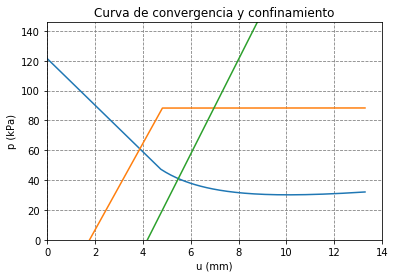

In [38]:
#Discretización de la presión y asignación de tamaños a los vectores a plotear
p=np.linspace(0.0, 1000.0, num=1000)
N=p.size
u_s=np.zeros(N)
p_s=np.zeros(N)
u_c=np.zeros(N)
p_c=np.zeros(N)
u_f=np.zeros(N)
p_f=np.zeros(N)

#Curva del suelo
for i in range(N):
    p_s[i]=pa(p[i])
    u_s[i]=us(p[i])
    
#Curva del frente
for i in range(N):
    u_f[i]=u_s[i]
    p_f[i]=pco(u_f[i]-uav-uco(0))
    
#Curva del revestimiento
for i in range(N):
    u_c[i]=u_s[i]
    p_c[i]=prev(u_c[i]-uio)

#Plot
plt.plot(u_s*1000,p_s) #ploteo de curva de suelo
plt.plot(u_f*1000,p_f) #ploteo de curva de frente
plt.plot(u_c*1000,p_c) #ploteo de curva de revestimiento

#Formato del gráfico
axes = plt.gca()
axes.set_xlim([0,14])
axes.set_ylim([0,1.2*gamma_s*Z0])
plt.grid(color='grey', linestyle='--')
plt.xlabel('u (mm)')
plt.ylabel('p (kPa)')
plt.title('Curva de convergencia y confinamiento')
plt.show()

In [34]:
print(u_s*1000)

[ 1.32891081e+01  1.27999266e+01  1.23454809e+01  1.19221980e+01
  1.15269788e+01  1.11571220e+01  1.08102619e+01  1.04843185e+01
  1.01774552e+01  9.88804415e+00  9.61463772e+00  9.35594402e+00
  9.11080656e+00  8.87818698e+00  8.65715031e+00  8.44685244e+00
  8.24652932e+00  8.05548773e+00  7.87309719e+00  7.69878311e+00
  7.53202063e+00  7.37232945e+00  7.21926913e+00  7.07243507e+00
  6.93145492e+00  6.79598546e+00  6.66570978e+00  6.54033480e+00
  6.41958911e+00  6.30322094e+00  6.19099649e+00  6.08269830e+00
  5.97812386e+00  5.87708436e+00  5.77940355e+00  5.68491669e+00
  5.59346965e+00  5.50491805e+00  5.41912653e+00  5.33596801e+00
  5.25532312e+00  5.17707959e+00  5.10113173e+00  5.02737996e+00
  4.95573040e+00  4.88609443e+00  4.81838833e+00  4.75253298e+00
  4.70176750e+00  4.63761335e+00  4.57345919e+00  4.50930504e+00
  4.44515088e+00  4.38099673e+00  4.31684258e+00  4.25268842e+00
  4.18853427e+00  4.12438011e+00  4.06022596e+00  3.99607180e+00
  3.93191765e+00  3.86776